In [56]:
# imports and setup 

import pandas as pd
import numpy as np

import torchvision
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch import Tensor

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold

In [57]:
# Create data fram with only m_label and pixel values
df = pd.read_csv("ARIAL.csv")
df = df.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])
# pd.set_option("display.max_rows", 30, "display.max_columns", None)
df

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,48,1,1,1,1,1,1,154,255,255,...,255,255,255,154,1,1,1,1,1,1
1,50,4,7,22,49,97,120,139,156,162,...,213,225,229,239,240,240,221,209,116,95
2,83,1,1,1,1,255,255,255,255,255,...,255,255,255,255,255,255,1,1,1,1
3,48,1,1,1,1,1,114,255,255,255,...,1,1,1,1,1,1,1,1,1,1
4,54,1,1,1,1,1,1,1,1,255,...,255,255,255,255,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26232,37,1,4,83,208,255,255,161,16,1,...,1,1,16,161,255,255,208,83,4,1
26233,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
26234,35,1,1,1,1,1,1,77,253,255,...,255,255,253,77,1,1,1,1,1,1
26235,34,43,255,255,255,255,255,255,255,255,...,43,255,255,255,255,213,1,1,1,1


In [58]:
df_pixel_values = df.drop(columns=['m_label'])
pixel_array = np.array(df_pixel_values)
# np.set_printoptions(threshold=np.inf)
pixel_array = pixel_array.astype(float)
for i in range(len(pixel_array)):
    for j in range(len(pixel_array[0])):
        pixel_array[i][j] = pixel_array[i][j] / 256

In [59]:
Xs = pixel_array # 20 x 20 array containing the pixel values
print(Xs.shape)
Xs = np.reshape(Xs, (-1, 1, 20, 20))
print(Xs.shape)
chars = set(df['m_label'])
uniqueChars = len(chars)
char_to_ix = {char: i for i, char in enumerate(chars)}
asciiValues = df['m_label']
lst = []
for ascii_val in asciiValues:
    lst.append(char_to_ix[ascii_val]) # creating list of index values of each ascii char label

Ys = np.array(lst) # convert list to numpy array

(26237, 400)
(26237, 1, 20, 20)


In [60]:
# Split data into testing and training sets
Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(Xs, Ys, random_state=1, test_size=0.75)
Xs_train = torch.tensor(Xs_train, dtype = torch.float)
Ys_train = torch.tensor(Ys_train, dtype = torch.float)
Xs_test = torch.tensor(Xs_test, dtype = torch.float)
Ys_test = torch.tensor(Ys_test, dtype = torch.float)

In [61]:
tensor_test = TensorDataset(Xs_test, Ys_test) 
tensor_train = TensorDataset(Xs_train, Ys_train) 

In [62]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        c1Out = 6 # convoluation layer 1 will output 6 "images": one for each filter it trains
        c2Out = 16 # similarly for the 2nd convolution layer
        self.conv1 = nn.Conv2d(1, c1Out, 3) #1-D input, c1Out outputs, filter size 3x3 pixels
        
        # (28-2)*(28 -2)*c1Out outputs

        self.pool = nn.MaxPool2d(2, 2) #downsample 2x2 blocks to 1 value
        
        # 13*13*c1Out
        
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3) #inputs comes from conv1 , specify our #outputs, use 3x3 blocks again
        
        # (13-2)*(13 -2)*c2Out
        # pool again
        # (11/2)*(11/2)*c2Out = 5*5*c2Out
        
        #this is tricky.  The convolutions each shave 1 pixel off around the border, and then the
        #max pools reduce the number of pixels by 4
        self.pooledOutputSize = c2Out*3*3 # 16 outputs per image whose size has been reduced
        self.fc1 = nn.Linear(self.pooledOutputSize, 120)
        self.fc2 = nn.Linear(120, 3098)

    def forward(self, x): # "batch" of images
        #x is 4D tensor:  (batch size, width, height, #channels (1, grayscale image))
        #after conv1:  (batch size, width adjusted, height adjusted, conv1 # outputs)
        #after max pool: (batch size, width/2, height/2, conv1 # outputs)
        # print("Before 1st: " + str(x.shape))
        # x = F.relu(self.conv1(x))
        x = self.conv1(x)
        # print("x = self.conv1(x) " + str(x.shape))
        x = F.relu(x)
        # print("x = F.relu(x) " + str(x.shape))
        x = self.pool(x)
        # print("Max Pool: " + str(x.shape))
        #split into 2 lines above
        #x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        # x = self.pool(F.relu(self.conv2(x))) #ditto
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        # print(x.shape)
        x = self.pool(x)
        # print("after pool before flatten " + str(x.shape))
        #print(x.shape) #uncomment to see the size of this layer.  It helped me figure out what pooledOutputSize shoudl be
        
        
        #turn the 5x5xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))
        # print("after flatten " + str(x.shape))
        # x = x.view(x.shape[0], -1)  #equivalent ways of reshaping the data to be 1D
        # x = x.view(batch_size( x.shape[0]) , -1)
        # print("after x = x.view(-1, self.num_flat_features(x)) " + str(x.shape))
        
        # x = F.relu(self.fc1(x)) #apply dense layer 1
        x = self.fc1(x)
        # print("dense layer1 " + str(x.shape))
        x = F.relu(x)
        # print(x.shape)
        # x = F.relu(self.fc2(x)) #and dense layer 2, using ReLU activation
        x = self.fc2(x)
        # print(x.shape)
        x = F.relu(x)
        # print(x.shape)
        
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

In [63]:
def train(model, epochs, tensor_train):
    criterion = nn.CrossEntropyLoss() #this is a way of measuring error for classification that takes the
    #"confidence" of a prediction into account.  High confidence, correct predictions are low cost, 
    #high confidence, wrong predictions are high cost, medium confidence predictions have cost

    #use the ADAM optimizer to find the best weights
    optimizer = optim.Adam(model.parameters(), lr= 1e-4) 
    
    #this loads data and gets it in the right format for us
    trainloader = torch.utils.data.DataLoader(tensor_train, batch_size=8, shuffle=True, num_workers=0)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs) #predict the output with some training data
            loss = criterion(outputs, labels.to(torch.long)) #see how well we did
            loss.backward() #see how to change the weights to do better
            optimizer.step() #and actually change the weights

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def evaluate(model, tensor_test):  
    #load some test data
    testloader = torch.utils.data.DataLoader(tensor_test, batch_size=8,
                                                shuffle=True, num_workers=0)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #just do a coarse evaluation... how many did we predict correcly?
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [64]:
train(net, 8, tensor_train)
evaluate(net, tensor_test)

Finished Training
Accuracy of the network on the 10000 test images: 7 %


The accuracy of the network seems to be between 11% - 22% after running it multiple times. 

In [65]:
class NxtNet(nn.Module):
    def __init__(self, uniqueChars):
        super(NxtNet, self).__init__()
        c1Out = 10 # convoluation layer 1 will output 6 "images": one for each filter it trains
        c2Out = 20 # similarly for the 2nd convolution layer
        self.conv1 = nn.Conv2d(1, c1Out, 3) #1-D input, c1Out outputs, filter size 3x3 pixels

        self.pool = nn.MaxPool2d(2, 2) #downsample 2x2 blocks to 1 value
        
        self.conv2 = nn.Conv2d(c1Out, c2Out, 3) #inputs comes from conv1 , specify our #outputs, use 3x3 
        self.conv2_norm = nn.BatchNorm2d(20)
        self.pooledOutputSize = c2Out*3*3 
        self.fc1 = nn.Linear(self.pooledOutputSize, 240)
        self.fc2 = nn.Linear(240, uniqueChars)

    def forward(self, x): # "batch" of images
        #x is 4D tensor:  (batch size, width, height, #channels (1, grayscale image))
        #after conv1:  (batch size, width adjusted, height adjusted, conv1 # outputs)
        #after max pool: (batch size, width/2, height/2, conv1 # outputs)
        # print("Before 1st: " + str(x.shape))
        # x = F.relu(self.conv1(x))
        x = self.conv1(x)
        # print("x = self.conv1(x) " + str(x.shape))
        x = F.relu(x)
        # print("x = F.relu(x) " + str(x.shape))
        x = self.pool(x)
        # print("Max Pool: " + str(x.shape))
        #split into 2 lines above
        #x = self.pool(F.relu(self.conv1(x)))  #apply convolution filter, then run it through relu activation function
        # x = self.pool(F.relu(self.conv2(x))) #ditto
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv2_norm(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.pool(x)
        # print("after pool before flatten " + str(x.shape))
        #print(x.shape) #uncomment to see the size of this layer.  It helped me figure out what pooledOutputSize shoudl be
        
        
        #turn the 5x5xc2Out array into a single 1xN array.  The dense layers expect a 1D thing
        x = x.view(-1, self.num_flat_features(x))
        # print("after flatten " + str(x.shape))
        # x = x.view(x.shape[0], -1)  #equivalent ways of reshaping the data to be 1D
        # x = x.view(batch_size( x.shape[0]) , -1)
        # print("after x = x.view(-1, self.num_flat_features(x)) " + str(x.shape))
        
        # x = F.relu(self.fc1(x)) #apply dense layer 1
        x = self.fc1(x)
        # print("dense layer1 " + str(x.shape))
        x = F.relu(x)
        # print(x.shape)
        # x = F.relu(self.fc2(x)) #and dense layer 2, using ReLU activation
        x = self.fc2(x)
        # print(x.shape)
        return x
    
    #compute the output size after our convolution layers
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


nxtnet = NxtNet(uniqueChars)

In [66]:
train(nxtnet, 20, tensor_train)
evaluate(nxtnet, tensor_test)

Finished Training
Accuracy of the network on the 10000 test images: 49 %


Adding batch normalization to the 2nd convolution increased accuracy from 18% to 50%

In [81]:
book_data = pd.read_csv("AGENCY.csv")
book_data

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,AGENCY,AGENCY FB,64258,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
1,AGENCY,AGENCY FB,64257,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
2,AGENCY,AGENCY FB,61442,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
3,AGENCY,AGENCY FB,61441,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
4,AGENCY,AGENCY FB,9674,0.4,0,0.0,51,21,33,25,...,255,132,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,AGENCY,AGENCY FB,37,0.7,1,0.0,35,27,51,48,...,255,255,255,231,114,1,1,1,1,1
1000,AGENCY,AGENCY FB,36,0.7,1,0.0,30,24,61,40,...,1,1,1,1,1,1,1,1,1,1
1001,AGENCY,AGENCY FB,35,0.7,1,0.0,35,25,51,44,...,1,1,1,1,1,1,1,1,1,1
1002,AGENCY,AGENCY FB,34,0.7,1,0.0,35,35,16,21,...,255,255,255,255,73,1,1,1,1,1


In [82]:
book_data = book_data.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])
book_pixel_values = book_data.drop(columns=['m_label'])
book_pixel_array = np.array(book_pixel_values)
book_pixel_array = book_pixel_array.astype(float)
for i in range(len(book_pixel_array)):
    for j in range(len(book_pixel_array[0])):
        book_pixel_array[i][j] = book_pixel_array[i][j] / 256

In [83]:
Xs = book_pixel_array # 20 x 20 array containing the pixel values
Xs = np.reshape(Xs, (-1, 1, 20, 20))
book_chars = set(book_data['m_label'])
uniqueChars = len(book_chars)
char_to_ix = {char: i for i, char in enumerate(book_chars)}
asciiValues = book_data['m_label']
lst = []
for ascii_val in asciiValues:
    lst.append(char_to_ix[ascii_val]) # creating list of index values of each ascii char label

Ys = np.array(lst) # convert list to numpy array
Ys

array([209, 208,   1, ...,  22, 224, 219])

In [84]:
# Split data into testing and training sets
Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(Xs, Ys, random_state=1, test_size=0.75)
Xs_train = torch.tensor(Xs_train, dtype = torch.float)
Ys_train = torch.tensor(Ys_train, dtype = torch.float)
Xs_test = torch.tensor(Xs_test, dtype = torch.float)
Ys_test = torch.tensor(Ys_test, dtype = torch.float)

In [85]:
tensor_test = TensorDataset(Xs_test, Ys_test) 
tensor_train = TensorDataset(Xs_train, Ys_train) 

In [88]:
train(nxtnet, 20, tensor_train)
evaluate(nxtnet, tensor_test)

Finished Training
Accuracy of the network on the 10000 test images: 11 %


In [89]:
train(net, 20, tensor_train)
evaluate(net, tensor_test)

Finished Training
Accuracy of the network on the 10000 test images: 0 %


In [174]:
bestNet = nxtnet
f = pd.read_csv('AGENCY.csv')
f2 = pd.read_csv('BRUSH.csv')
f3 = pd.read_csv('BOOK.csv')
data1 = f.loc[:, 'r0c0':]
data2 = f2.loc[:, 'r0c0':]
data3 = f3.loc[:, 'r0c0':]

mixed_fonts_labels = pd.concat([f['m_label'], f2['m_label'], f3['m_label']]).reset_index(drop=True)
mixed_fonts = pd.concat([data1, data2, data3]).reset_index(drop=True)

In [175]:
Xs = np.array(mixed_fonts)
Xs = Xs.astype(float)
for i in range(len(Xs)):
    for j in range(len(Xs[0])):
        Xs[i][j] = Xs[i][j] / 256
Xs = np.reshape(Xs, (-1, 1, 20, 20))
chars = set(mixed_fonts_labels)
uniqueChars = len(chars)
char_to_ix = {char: i for i, char in enumerate(chars)}
asciiValues = mixed_fonts_labels
lst = []
for ascii_val in asciiValues:
    lst.append(char_to_ix[ascii_val]) # creating list of index values of each ascii char label

Ys_mixed = np.array(lst) # convert list to numpy array
Xs_mixed = Xs
print(Ys_mixed.shape)
print(Xs_mixed.shape)

(4628,)
(4628, 1, 20, 20)


In [176]:
Xs_mixed_train, Xs_mixed_test, Ys_mixed_train, Ys_mixed_test = train_test_split(Xs_mixed[:-len(f3)], Ys_mixed[:-len(f3)])
Xs_mixed_train = torch.tensor(Xs_mixed_train, dtype = torch.float)
Ys_mixed_train = torch.tensor(Ys_mixed_train, dtype = torch.float)
Xs_mixed_test = torch.tensor(Xs_mixed_test, dtype = torch.float)
Ys_mixed_test = torch.tensor(Ys_mixed_test, dtype = torch.float)

In [177]:
tensor_mixed_test = TensorDataset(Xs_mixed_test, Ys_mixed_test) 
tensor_mixed_train = TensorDataset(Xs_mixed_train, Ys_mixed_train) 

In [179]:
best_network_mixed = NxtNet(uniqueChars


train(best_network_mixed, 20, tensor_mixed_train)
evaluate(best_network_mixed, tensor_mixed_test)


Finished Training
Accuracy of the network on the 10000 test images: 48 %


Accuracy increased from 11% - 48% using the multiple font set instead of 1 font

In [181]:
test_data_not_trained = TensorDataset( Tensor(Xs_mixed[-len(f3):]), Tensor(Ys_mixed[-len(f3):]).to(torch.long))

evaluate(best_network_mixed, test_data_not_trained)

Accuracy of the network on the 10000 test images: 12 %


Accuracy is lower when testing with inputs from a font not trained on. It kinda makes sense, even though the model was trained with two different fonts, it wasn't trained in this one, so it is not prepared to classify this font style correctly.  

In [186]:
unicode_to_labels = {unicode: i for i, unicode in enumerate(chars) }
labels_to_unicode = {label: unicode for unicode, label in unicode_to_labels.items() }

In [193]:
def getMisclassified(model, test_data):
    test_to_predict = [] # CHANGE THIS
    testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False, num_workers=0)
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_to_predict += list(zip(list(labels.numpy()), list(predicted.numpy())))

    misclassified = []

    for i, item in enumerate(test_to_predict):
        if (item[0] != item[1]):
            actual = chr(labels_to_unicode[item[0]])
            predicted = chr(labels_to_unicode[item[1]])
            misclassified.append((i, actual, predicted))

    return misclassified

In [194]:
missed = getMisclassified(best_network_mixed, tensor_mixed_test)

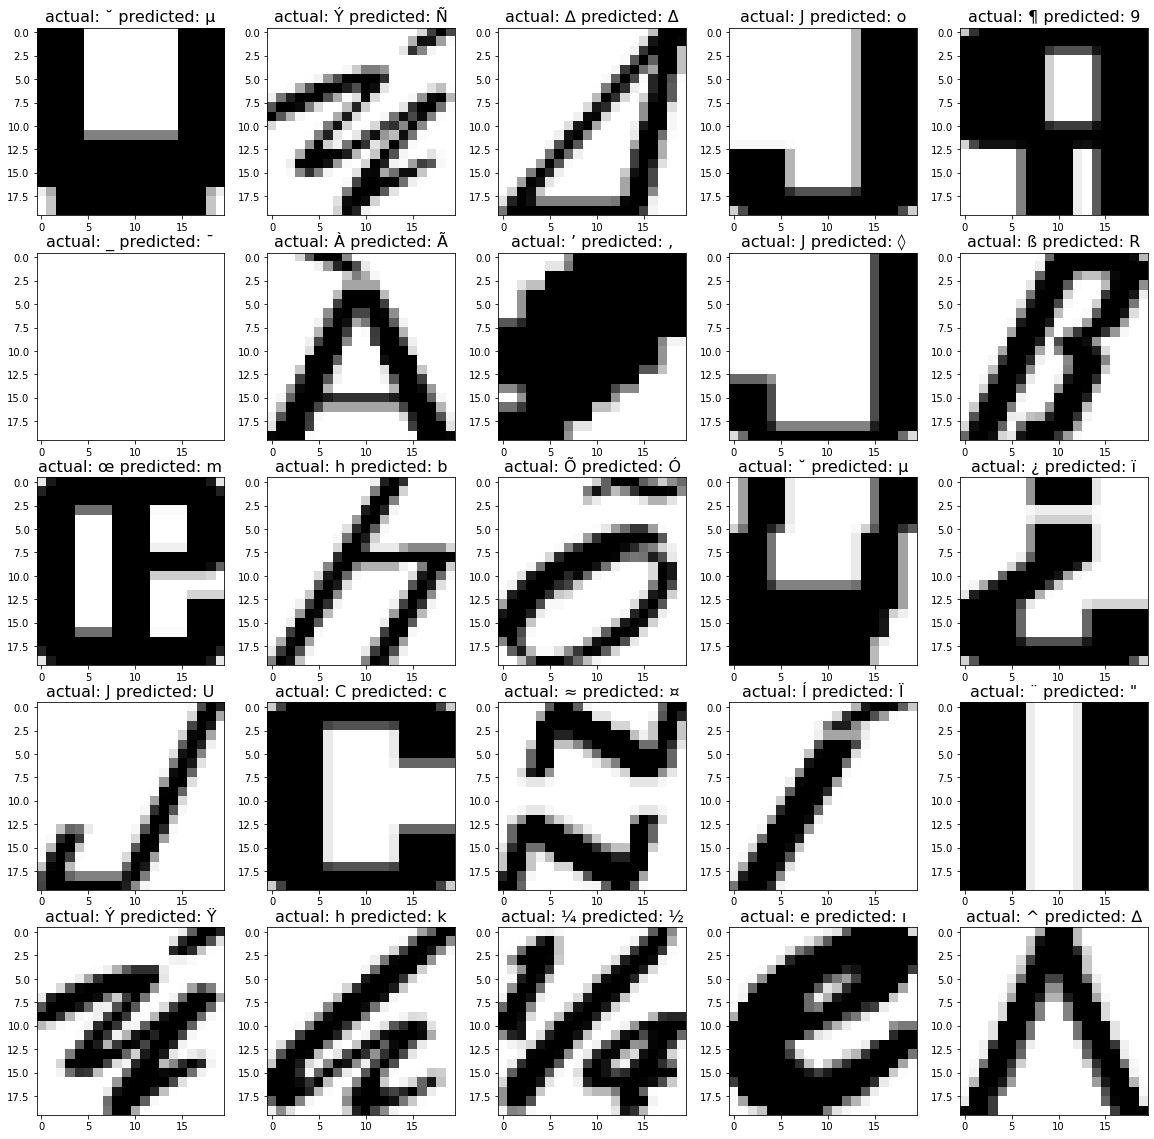

In [195]:
plt.figure(figsize=(20,20))
for ii in np.arange(25):
    index = missed[ii][0]
    actual_chr = missed[ii][1]
    predicted_chr = missed[ii][2]

    plt.subplot(5, 5, ii+1)
    plt.imshow(Xs_mixed_test[index, 0, :, :], cmap='Greys', interpolation='none')
    plt.title("actual: " + actual_chr + " predicted: " + predicted_chr, fontsize=16)